# Imports

In [ ]:
!pip install nervaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip -q install ktrain requests

     |████████████████████████████████| 25.3 MB 1.2 MB/s 
     |████████████████████████████████| 981 kB 54.7 MB/s 
     |████████████████████████████████| 265 kB 52.7 MB/s 
     |████████████████████████████████| 3.8 MB 58.7 MB/s 
     |████████████████████████████████| 1.3 MB 95.3 MB/s 
     |████████████████████████████████| 468 kB 31.6 MB/s 
     |████████████████████████████████| 182 kB 74.4 MB/s 
     |████████████████████████████████| 7.6 MB 59.8 MB/s 
     |████████████████████████████████| 880 kB 41.9 MB/s 


In [ ]:
!python -m spacy download pt_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 104.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [ ]:
import pandas as pd
import numpy as np
import json
import pickle as pkl

import yaml

import ktrain 
from ktrain import text as txt

import uuid

import re
import spacy
from spacy.lang.pt.examples import sentences 
from spacy.training import offsets_to_biluo_tags

# Utils

In [ ]:
nlp = spacy.load('pt_core_news_sm')

entidadesExtratoContrato = ['data_assinatura_contrato',
                            'partes_contratuais',
                            'natureza_despesa',
                            'nota_empenho',
                            'numero_contrato',
                            'objeto_contrato',
                            'processo_gdf',
                            'programa_trabalho',
                            'unidade_orcamentaria',
                            'valor_contrato',
                            'vigencia_contrato'
                            ]

def get_token_for_char(doc, char_idx):
    for i, token in enumerate(doc):
        if  token.idx <= char_idx <= token.idx+len(token.text):
            return token.idx,len(token.text)

def get_span(text, label, ent):
    span = {'label':label, 'start':0, 'end':0}
    doc = nlp(text)
    if ent in doc.text:
        t1 = get_token_for_char(doc,doc.text.index(ent))
        t2 = get_token_for_char(doc,doc.text.index(ent)+len(ent))
        span['start'] = t1[0]
        span['end'] = t2[0]+t2[1]
        #print(doc.text[span['start']:span['end']])
    return span

def entity_to_span(text, value, key):
    span_list = []
    e=0
    text = re.sub('\n', ' ', text)
    for entity in value:
        doc = nlp(text)
        ent = re.sub('\n', ' ', entity.replace(r'\n', '\n'))
        #print(text, '\n\t\t',key,'->', ent,'\n\n')
        #print(ent)
        span = {'label':key, 'start':0, 'end':0}
        #ent = entity[0]
        if ent in doc.text:
            #print(ent)
            #print(doc.text)
            t1 = get_token_for_char(doc,doc.text.index(ent))
            #print(doc.text.index(ent)+len(ent)-1)
            t2 = get_token_for_char(doc,doc.text.index(ent)+len(ent))
            span['start'] = t1[0]
            span['end'] = t2[0]+t2[1]
            #print(doc.text[span['start']:span['end']])
            if(span['start']!=0 and span['end']!=0):
                span_list.append((span['start']+e,span['end']+e,span['label']))
            e+=span['end']
            text = text[span['end']:]
    return span_list

# testando prediçoes coflitantes
# '(948, 958, 'data_assinatura_contrato')' and '(907, 1101, 'vigencia_contrato')'
def ajust_preds(text,preds,preds2):
    #print(preds)
    text = re.sub('\n', ' ', text)
    for p1 in preds:
        for p2 in preds:
            #print(p1,p2)
            if ((p2[0]<=p1[0] and p1[0]<=p2[1]) or (p2[0]<=p1[1] and p1[1]<=p2[1])) and p1 != p2:
                # print('p1:', p1)
                # print('p2:', p2)
                ent = text[p1[0]:p1[1]]
                label = p1[2]
                #print(ent)
                text_aux = text[p2[1]:]
                idx0 = p2[0]
                idx1 = p2[1]
                flag = 0
                # Procura no texto por outra ocorrencia
                while flag == 0:
                    flag = 1
                    span = get_span(text_aux,label,ent)
                    #print(span)
                    for p3 in preds:
                        # testa se esta occorencia ja está em alguma outra entidade, se sim continua procurando, se não encontrou a ocorrencia desejada
                        if ((p3[0]<=(span['start']+idx1)<=p3[1]) or (p3[0]<=(span['end']+idx1)<=p3[1])) and (span['start']!=0 and span['end']!=0):
                            #print('p3[0]:',p3[0])
                            #print('p3[1]:',p3[1])
                            flag = 0
                            text_aux = text[p3[1]:]
                            #print(text_aux)
                            idx0 = p3[0]
                            idx1 = p3[1]
                            # print(f"{span['start']} + {idx1} = {span['start']+idx1}")
                            # print(f"{span['end']} + {idx1} = {span['end']+idx1}")
                            #break
                # se achou um acorrencia que não faz parte de outra entidade, remove sua ocorrencia anterior e adiciona a nova
                if(span['start']!=0 and span['end']!=0):
                    #print('trocou p1: ', p1)
                    #print('por: ', (span['start']+idx1,span['end']+idx1,span['label']))
                    preds.remove(p1)
                    preds.append((span['start']+idx1,span['end']+idx1,span['label']))
                    return preds,preds2,0
                # se não achou nenhuma nova ocorrencia, devemos retirar a ocorrencia de maior tamanho, pois é provavel que essa esteja afetando a ocorrencia menor
                else:
                    ent = text[p2[0]:p2[1]]
                    label = p2[2]
                    #print(ent)
                    text_aux = text[p1[1]:]
                    idx0 = p1[0]
                    idx1 = p1[1]
                    flag = 0
                    while flag == 0:
                        flag = 1
                        span = get_span(text_aux,label,ent)
                        #print(span)
                        for p3 in preds:
                            # testa se esta occorencia ja está em alguma outra entidade, se sim continua procurando, se não encontrou a ocorrencia desejada
                            if ((p3[0]<=(span['start']+idx1)<=p3[1]) or (p3[0]<=(span['end']+idx1)<=p3[1])) and (span['start']!=0 and span['end']!=0):
                                #print('p3[0]:',p3[0])
                                #print('p3[1]:',p3[1])
                                flag = 0
                                text_aux = text[p3[1]:]
                                #print(text_aux)
                                idx0 = p3[0]
                                idx1 = p3[1]
                                # print(f"{span['start']} + {idx1} = {span['start']+idx1}")
                                # print(f"{span['end']} + {idx1} = {span['end']+idx1}")
                                #break
                    if(span['start']!=0 and span['end']!=0):
                        #print('trocou p1: ', p1)
                        #print('por: ', (span['start']+idx1,span['end']+idx1,span['label']))
                        preds.remove(p2)
                        preds.append((span['start']+idx1,span['end']+idx1,span['label']))
                        return preds,preds2,0
                    else:
                        #print('removeu p1: ', p1)
                        preds2.append(p1)
                        preds.remove(p1)
                        return preds,preds2,0
    return preds,preds2,1

def mix_final_preds(final_preds):
    for i in range(len(final_preds)):
        for j in range(i,len(final_preds)):
            for p1 in final_preds[i]:
                flag = 1
                for p2 in final_preds[j]:
                    if ((p2[0]<=p1[0]<=p2[1]) or (p2[0]<=p1[1]<=p2[1]) or (p1[0]<=p2[0]<=p1[1]) or (p1[0]<=p2[1]<=p1[1])):
                        flag = 0
                if flag==1:
                    final_preds[j].append(p1)
    return final_preds

def rec_ajust_preds(text,preds):
    final_preds = []
    preds2 = []
    teste = 0
    while teste != 1:
        preds,preds2, teste = ajust_preds(text,preds,preds2)
    if(preds2==[]):
        return [preds]
    else:
        final_preds.append(preds)
        for pred in rec_ajust_preds(text,preds2):
            final_preds.append(pred)
        # Junta as predições que não sobresaeem uma da outra
        return mix_final_preds(final_preds)

def get_list_spans(text,labels_dict):
    #labels_dict = yaml.safe_load(labels_dict)
    lista = []
    for key, value in labels_dict.items():
        if key not in entidadesExtratoContrato:
          continue
        #pred = ajust_preds(text,entity_to_span(text,value,key))
        pred = entity_to_span(text,value,key)
        for i in pred:
            lista.append(i)
    #print(lista)
    return rec_ajust_preds(text,lista)

In [ ]:
def tokenize(texto,labels):
    if isinstance(labels, str):
        labels = yaml.safe_load(re.sub('\n', ' ', labels.replace(r'\n', '\n')))
        
    nlp = spacy.load('pt_core_news_sm')
    preds = get_list_spans(texto,labels)

    conll=''
    for pred in preds:

        text = re.sub('\n', ' ', texto)
        doc = nlp(text)

        tags = offsets_to_biluo_tags(doc, pred)

        for i in range(len(doc)):
            if tags[i][0] == 'U':
                conll += doc[i].text + ' ' + 'B' + tags[i][1:] + '\n'
            elif tags[i][0] == 'L':
                conll += doc[i].text + ' ' + 'I' + tags[i][1:] + '\n'
            else:
                conll += doc[i].text + ' ' + tags[i] + '\n'
              
        conll+='\n'

    return conll

In [ ]:
# Função que gera string no formato Conll a partir das predições dos modelos
def get_conll_conc(pred):
  conll_conc = ""
  for i, tupla in enumerate(pred):
      txt,ent = tupla[0],tupla[1]
      if ent =='O':
        conll_conc += txt + ' O\n'
      else:
        if(i!=0 and pred[i-1][1]==ent):
          conll_conc += txt + ' '+ ent +'\n'
        else:
          conll_conc += txt + ' '+ ent +'\n'
  return conll_conc+'\n'

In [ ]:
# função que trasnforma as prediçõe dos modelos ktrain em dicionarios para facilitar a comparação sem depender de tokenizações
def get_entities_from_prediction(predictions):
    lista = []
    cont = 0
    for pred in predictions:
        ents_dit = {}
        i=0
        while (i < len(pred)):
            txt,ent = pred[i][0],pred[i][1]
            if ent !='O':
                aux_txt = txt
                while(len(pred) > i+1 and pred[i+1][1] != 'O'):
                    if(pred[i+1][1][2:] == ent[2:]):
                        aux_txt += ' ' + pred[i+1][0]
                        i+=1
                    else:
                        break
                if(ent[2:] in ents_dit):
                    ents_dit[ent[2:]].append(aux_txt)
                else:
                    ents_dit[ent[2:]] = [aux_txt]
            i+=1
        lista.append(ents_dit)
        cont+=1
    return lista

# Carregando dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import gdown

# url = 'https://drive.google.com/drive/folders/1AJitYBCAc-vI5kgcAGEVV5oD4q9EmVoZ?usp=sharing'

# gdown.download_folder(url)

In [ ]:
#CONLL BASE COM 783 atos pelo GPT Mais os atos combinados em usa porcentagems
VAL_DATA = "/content/drive/MyDrive/tccF/val_conll.conll"
BASE_DATA_10 = "/content/drive/MyDrive/Conll_IT/Combined/conll_110.conll"
BASE_DATA_20 = "/content/drive/MyDrive/Conll_IT/Combined/conll_120.conll"
BASE_DATA_30 = "/content/drive/MyDrive/Conll_IT/Combined/conll_130.conll"
BASE_DATA_40 = "/content/drive/MyDrive/Conll_IT/Combined/conll_140.conll"
BASE_DATA_50 = "/content/drive/MyDrive/Conll_IT/Combined/conll_150.conll"
BASE_DATA_60 = "/content/drive/MyDrive/Conll_IT/Combined/conll_160.conll"
BASE_DATA_70 = "/content/drive/MyDrive/Conll_IT/Combined/conll_170.conll"
BASE_DATA_80 = "/content/drive/MyDrive/Conll_IT/Combined/conll_180.conll"
BASE_DATA_90 = "/content/drive/MyDrive/Conll_IT/Combined/conll_190.conll"
BASE_DATA_100 = "/content/drive/MyDrive/Conll_IT/Combined/conll_200.conll"

In [ ]:
# Dataframe que servirá para o treinamento iterativo dos modelos
# df_test = pd.read_csv('/content/tccF/df_test.csv')
df_test = pd.read_csv('/content/drive/MyDrive/tccF/df_test.csv')
df_test.drop('Unnamed: 0', axis=1, inplace=True)
df_test

id    id_ato                                              texto  \
0    444   631-R47  EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1     51   634-R93  EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    140  628-R103  EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    242   630-R76  EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    624   671-R49  EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..   ...       ...                                                ...   
375  273  637-R130  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  594  626-R141  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  704  639-R143  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  436   631-R35  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  637    640-R1  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                                 label  
0    {'partes_contratuais': ['INSTITUTO DE ASSIST. ...  
1    {'numero_contrato': ['45384/2021', '45384/2021...  
2    {'partes_contratuais': ['DF/SECEC/FAC', 'WAYNE...  
3    {'natureza_despesa': ['339039'], 'numero_contr...  
4    {'partes_contratuais': ['Companhia de Planejam...  
..                                                 ...  
375  {'partes_contratuais': ['SECRETARIA DE ESTADO ...  
376  {'natureza_despesa': ['449052'], 'partes_contr...  
377  {'partes_contratuais': ['INSTITUTO DE ASSIST. ...  
378  {'partes_contratuais': ['INSTITUTO DE ASSIST. ...  
379  {'numero_contrato': ['26/2022'], 'processo_gdf...  

[380 rows x 4 columns]

In [ ]:
print(len(df_test))

380


In [ ]:
# definindo as samples (textos dos atos) em que serão aplicados os modelo
test_data = [ [df_test['id'][j],df_test['texto'][j],df_test['label'][j]]  for j in range(len(list(df_test['id']))) ]
samples = [test_data[i][1] for i in range(len(test_data))]
print(len(samples))

380


In [ ]:
samples[0]

'EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04001-0000000210/2021-91. Das Partes: INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS na qualidade de CONTRATANTE, COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA na qualidade de CONTRATADA. Do Objeto: CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO. DO VALOR: R$ 55,843.60 (cinquenta e cinco mil e oitocentos e quarenta e três reais e sessenta centavos) e correrá à conta de dotações orçamentárias consignadas no orçamento corrente - Lei Orçamentária Anual. DA DOTAÇÃO ORÇAMENTÁRIA: A despesa correrá à conta da seguinte Dotação Orçamentária: DOTAÇÃO ORÇAMENTÁRIA: UO:19212; PROGRAMA DE TRABALHO: 10122620361957, FONTE DE RECURSO: 220000000; UG: 140202; GESTÃO: 14202; EMPENHO 2021NE0/0129, DATADO DE: 21/07/2021, VALOR DO EMPENHO: R$ 55,843.60 (cinquenta

# Treinando Modelos

## BERT PORTUGUESE 10

In [ ]:
print('\n***************************************')
print('TREINANDO BERT PORTUGUESE....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_10,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model_bert_portuguese = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='neuralmind/bert-base-portuguese-cased')

# INSTANCIANDO LEARNER
learner_bert_portuguese = ktrain.get_learner(
    model_bert_portuguese, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_bert_portuguese.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor_bert_portuguese = ktrain.get_predictor(
    learner_bert_portuguese.model, preproc)



***************************************
TREINANDO BERT PORTUGUESE....
***************************************



Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505M [00:00<?, ?B/s]



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
9/9 [==============================] - 78s 7s/step - loss: 0.8508 - val_loss: 0.6866
Epoch 2/10
9/9 [==============================] - 67s 8s/step - loss: 0.4625 - val_loss: 0.5002
Epoch 3/10
9/9 [==============================] - 67s 8s/step - loss: 0.3720 - val_loss: 0.3947
Epoch 4/10
9/9 [==============================] - 67s 8s/step - loss: 0.3288 - val_loss: 0.3827
Epoch 5/10
9/9 [==============================] - 67s 8s/step - loss: 0.2929 - val_loss: 0.2899
Epoch 6/10
9/9 [==============================] - 67s 8s/step - loss: 0.2646 - val_loss: 0.2665
Epoch 7/10
9/9 [==============================] - 67s 8s/step - loss: 0.2459 - val_loss: 0.2804
Epoch 8/10
9/9 [==============================] - 67s 8s/step - loss: 0.2284 - val_loss: 0.2644
Epoch 9/10
9/9 [==============================] - 67s 8s/step - loss: 0.2137 - val_los

In [ ]:
dict_portuguese10 = get_entities_from_prediction(predictor_bert_portuguese.predict(samples))

In [ ]:
learner_bert_portuguese.validate()

   F1:  47.51
                          precision    recall  f1-score   support

data_assinatura_contrato       0.77      0.55      0.64       171
        natureza_despesa       0.88      0.65      0.75       262
            nota_empenho       0.98      0.72      0.83       328
         numero_contrato       0.95      0.77      0.85       458
         objeto_contrato       0.13      0.41      0.20       385
      partes_contratuais       0.19      0.22      0.21       741
            processo_gdf       0.84      0.90      0.87       411
       programa_trabalho       0.75      0.58      0.65       345
    unidade_orcamentaria       0.88      0.28      0.42       287
          valor_contrato       0.90      0.71      0.79       362
       vigencia_contrato       0.04      0.09      0.05       309

               micro avg       0.44      0.52      0.48      4059
               macro avg       0.66      0.53      0.57      4059
            weighted avg       0.62      0.52      0.54     

0.4750733137829912

In [ ]:
# path = '/content/drive/MyDrive/Conll_IT/Results/bert_portuguese10'
# ktrain.get_predictor(model_bert_portuguese, preproc).save(path)

with open("/content/drive/MyDrive/Conll_IT/Results/dict_portuguese10.pkl", "wb") as f:
    pkl.dump(dict_portuguese10, f)

## BERT PORTUGUESE 20

In [ ]:
print('\n***************************************')
print('TREINANDO BERT PORTUGUESE....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_20,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model_bert_portuguese = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='neuralmind/bert-base-portuguese-cased')

# INSTANCIANDO LEARNER
learner_bert_portuguese = ktrain.get_learner(
    model_bert_portuguese, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_bert_portuguese.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor_bert_portuguese = ktrain.get_predictor(
    learner_bert_portuguese.model, preproc)



***************************************
TREINANDO BERT PORTUGUESE....
***************************************



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
10/10 [==============================] - 82s 7s/step - loss: 0.7786 - val_loss: 0.5468
Epoch 2/10
10/10 [==============================] - 71s 7s/step - loss: 0.4027 - val_loss: 0.4047
Epoch 3/10
10/10 [==============================] - 71s 7s/step - loss: 0.3431 - val_loss: 0.3106
Epoch 4/10
10/10 [==============================] - 71s 7s/step - loss: 0.2986 - val_loss: 0.3028
Epoch 5/10
10/10 [==============================] - 71s 7s/step - loss: 0.2689 - val_loss: 0.2478
Epoch 6/10
10/10 [==============================] - 71s 7s/step - loss: 0.2492 - val_loss: 0.2468
Epoch 7/10
10/10 [==============================] - 71s 7s/step - loss: 0.2320 - val_loss: 0.2221
Epoch 8/10
10/10 [==============================] - 71s 

In [ ]:
dict_portuguese20 = get_entities_from_prediction(predictor_bert_portuguese.predict(samples))

In [ ]:
learner_bert_portuguese.validate()

   F1:  50.50
                          precision    recall  f1-score   support

data_assinatura_contrato       0.78      0.54      0.64       171
        natureza_despesa       0.96      0.66      0.78       262
            nota_empenho       0.96      0.75      0.85       328
         numero_contrato       0.95      0.76      0.84       458
         objeto_contrato       0.16      0.43      0.23       385
      partes_contratuais       0.19      0.26      0.22       741
            processo_gdf       0.74      0.76      0.75       411
       programa_trabalho       0.79      0.53      0.63       345
    unidade_orcamentaria       0.90      0.62      0.73       287
          valor_contrato       0.93      0.78      0.85       362
       vigencia_contrato       0.08      0.16      0.11       309

               micro avg       0.47      0.55      0.51      4059
               macro avg       0.68      0.57      0.60      4059
            weighted avg       0.62      0.55      0.57     

0.5050413504021751

In [ ]:
# path = '/content/drive/MyDrive/Conll_IT/Results/bert_portuguese20'
# ktrain.get_predictor(model_bert_portuguese, preproc).save(path)

with open("/content/drive/MyDrive/Conll_IT/Results/dict_portuguese20.pkl", "wb") as f:
    pkl.dump(dict_portuguese20, f)

## BERT PORTUGUESE 30

In [ ]:
print('\n***************************************')
print('TREINANDO BERT PORTUGUESE....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_30,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model_bert_portuguese = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='neuralmind/bert-base-portuguese-cased')

# INSTANCIANDO LEARNER
learner_bert_portuguese = ktrain.get_learner(
    model_bert_portuguese, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_bert_portuguese.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor_bert_portuguese = ktrain.get_predictor(
    learner_bert_portuguese.model, preproc)



***************************************
TREINANDO BERT PORTUGUESE....
***************************************



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
11/11 [==============================] - 86s 7s/step - loss: 0.7963 - val_loss: 0.4925
Epoch 2/10
11/11 [==============================] - 75s 7s/step - loss: 0.3763 - val_loss: 0.3606
Epoch 3/10
11/11 [==============================] - 75s 7s/step - loss: 0.3110 - val_loss: 0.2759
Epoch 4/10
11/11 [==============================] - 75s 7s/step - loss: 0.2740 - val_loss: 0.2711
Epoch 5/10
11/11 [==============================] - 75s 7s/step - loss: 0.2559 - val_loss: 0.2901
Epoch 6/10
11/11 [==============================] - 75s 7s/step - loss: 0.2327 - val_loss: 0.2170
Epoch 7/10
11/11 [==============================] - 75s 7s/step - loss: 0.2256 - val_loss: 0.2194
Epoch 8/10
11/11 [==============================] - 75s 

In [ ]:
dict_portuguese30 = get_entities_from_prediction(predictor_bert_portuguese.predict(samples))

In [ ]:
learner_bert_portuguese.validate()

   F1:  64.84
                          precision    recall  f1-score   support

data_assinatura_contrato       0.75      0.68      0.71       171
        natureza_despesa       0.93      0.81      0.87       262
            nota_empenho       0.97      0.93      0.95       328
         numero_contrato       0.90      0.86      0.88       458
         objeto_contrato       0.19      0.48      0.27       385
      partes_contratuais       0.35      0.46      0.40       741
            processo_gdf       0.85      0.95      0.89       411
       programa_trabalho       0.88      0.81      0.85       345
    unidade_orcamentaria       0.96      0.75      0.84       287
          valor_contrato       0.87      0.88      0.88       362
       vigencia_contrato       0.33      0.56      0.42       309

               micro avg       0.59      0.72      0.65      4059
               macro avg       0.72      0.74      0.72      4059
            weighted avg       0.68      0.72      0.69     

0.648414985590778

In [ ]:
# path = '/content/drive/MyDrive/Conll_IT/Results/bert_portuguese30'
# ktrain.get_predictor(model_bert_portuguese, preproc).save(path)

with open("/content/drive/MyDrive/Conll_IT/Results/dict_portuguese30.pkl", "wb") as f:
    pkl.dump(dict_portuguese30, f)

## BERT PORTUGUESE 40

In [ ]:
print('\n***************************************')
print('TREINANDO BERT PORTUGUESE....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_40,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model_bert_portuguese = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='neuralmind/bert-base-portuguese-cased')

# INSTANCIANDO LEARNER
learner_bert_portuguese = ktrain.get_learner(
    model_bert_portuguese, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_bert_portuguese.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor_bert_portuguese = ktrain.get_predictor(
    learner_bert_portuguese.model, preproc)



***************************************
TREINANDO BERT PORTUGUESE....
***************************************



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
12/12 [==============================] - 91s 7s/step - loss: 0.7385 - val_loss: 0.5504
Epoch 2/10
12/12 [==============================] - 79s 7s/step - loss: 0.3839 - val_loss: 0.4078
Epoch 3/10
12/12 [==============================] - 79s 7s/step - loss: 0.3062 - val_loss: 0.2858
Epoch 4/10
12/12 [==============================] - 79s 7s/step - loss: 0.2674 - val_loss: 0.2424
Epoch 5/10
12/12 [==============================] - 79s 7s/step - loss: 0.2384 - val_loss: 0.2320
Epoch 6/10
12/12 [==============================] - 79s 7s/step - loss: 0.2248 - val_loss: 0.2211
Epoch 7/10
12/12 [==============================] - 79s 7s/step - loss: 0.2149 - val_loss: 0.2392
Epoch 8/10
12/12 [==============================] - 79s 

In [ ]:
dict_portuguese40 = get_entities_from_prediction(predictor_bert_portuguese.predict(samples))

In [ ]:
learner_bert_portuguese.validate()

   F1:  62.76
                          precision    recall  f1-score   support

data_assinatura_contrato       0.83      0.64      0.72       171
        natureza_despesa       0.94      0.81      0.87       262
            nota_empenho       0.97      0.91      0.94       328
         numero_contrato       0.92      0.87      0.89       458
         objeto_contrato       0.14      0.40      0.21       385
      partes_contratuais       0.39      0.51      0.44       741
            processo_gdf       0.86      0.93      0.89       411
       programa_trabalho       0.81      0.74      0.77       345
    unidade_orcamentaria       0.78      0.86      0.82       287
          valor_contrato       0.79      0.92      0.85       362
       vigencia_contrato       0.25      0.40      0.31       309

               micro avg       0.56      0.71      0.63      4059
               macro avg       0.70      0.73      0.70      4059
            weighted avg       0.66      0.71      0.68     

0.6275787187839305

In [ ]:
# path = '/content/drive/MyDrive/Conll_IT/Results/bert_portuguese40'
# ktrain.get_predictor(model_bert_portuguese, preproc).save(path)

with open("/content/drive/MyDrive/Conll_IT/Results/dict_portuguese40.pkl", "wb") as f:
    pkl.dump(dict_portuguese40, f)

## BERT PORTUGUESE 50

In [ ]:
print('\n***************************************')
print('TREINANDO BERT PORTUGUESE....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_50,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model_bert_portuguese = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='neuralmind/bert-base-portuguese-cased')

# INSTANCIANDO LEARNER
learner_bert_portuguese = ktrain.get_learner(
    model_bert_portuguese, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_bert_portuguese.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor_bert_portuguese = ktrain.get_predictor(
    learner_bert_portuguese.model, preproc)



***************************************
TREINANDO BERT PORTUGUESE....
***************************************



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
12/12 [==============================] - 94s 7s/step - loss: 0.7857 - val_loss: 0.5214
Epoch 2/10
12/12 [==============================] - 83s 7s/step - loss: 0.3887 - val_loss: 0.3662
Epoch 3/10
12/12 [==============================] - 83s 7s/step - loss: 0.3143 - val_loss: 0.2896
Epoch 4/10
12/12 [==============================] - 83s 7s/step - loss: 0.2639 - val_loss: 0.2424
Epoch 5/10
12/12 [==============================] - 83s 7s/step - loss: 0.2535 - val_loss: 0.2387
Epoch 6/10
12/12 [==============================] - 82s 7s/step - loss: 0.2362 - val_loss: 0.2228
Epoch 7/10
12/12 [==============================] - 83s 7s/step - loss: 0.2206 - val_loss: 0.2083
Epoch 8/10
12/12 [==============================] - 83s 

In [ ]:
dict_portuguese50 = get_entities_from_prediction(predictor_bert_portuguese.predict(samples))

In [ ]:
learner_bert_portuguese.validate()

   F1:  49.54
                          precision    recall  f1-score   support

data_assinatura_contrato       0.82      0.57      0.67       171
        natureza_despesa       0.91      0.72      0.80       262
            nota_empenho       0.98      0.70      0.82       328
         numero_contrato       0.95      0.73      0.83       458
         objeto_contrato       0.17      0.41      0.24       385
      partes_contratuais       0.13      0.14      0.14       741
            processo_gdf       0.75      0.80      0.77       411
       programa_trabalho       0.82      0.60      0.69       345
    unidade_orcamentaria       0.96      0.58      0.72       287
          valor_contrato       0.94      0.63      0.75       362
       vigencia_contrato       0.02      0.04      0.03       309

               micro avg       0.48      0.51      0.50      4059
               macro avg       0.68      0.54      0.59      4059
            weighted avg       0.62      0.51      0.55     

0.49535976859105696

In [ ]:
# path = '/content/drive/MyDrive/Conll_IT/Results/bert_portuguese50'
# ktrain.get_predictor(model_bert_portuguese, preproc).save(path)

with open("/content/drive/MyDrive/Conll_IT/Results/dict_portuguese50.pkl", "wb") as f:
    pkl.dump(dict_portuguese50, f)

## BERT PORTUGUESE 60

In [ ]:
print('\n***************************************')
print('TREINANDO BERT PORTUGUESE....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_60,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model_bert_portuguese = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='neuralmind/bert-base-portuguese-cased')

# INSTANCIANDO LEARNER
learner_bert_portuguese = ktrain.get_learner(
    model_bert_portuguese, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_bert_portuguese.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor_bert_portuguese = ktrain.get_predictor(
    learner_bert_portuguese.model, preproc)



***************************************
TREINANDO BERT PORTUGUESE....
***************************************



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
13/13 [==============================] - 98s 7s/step - loss: 0.7795 - val_loss: 0.4853
Epoch 2/10
13/13 [==============================] - 86s 7s/step - loss: 0.3650 - val_loss: 0.3334
Epoch 3/10
13/13 [==============================] - 86s 7s/step - loss: 0.2882 - val_loss: 0.2848
Epoch 4/10
13/13 [==============================] - 86s 7s/step - loss: 0.2565 - val_loss: 0.2621
Epoch 5/10
13/13 [==============================] - 86s 7s/step - loss: 0.2340 - val_loss: 0.2410
Epoch 6/10
13/13 [==============================] - 87s 7s/step - loss: 0.2145 - val_loss: 0.2005
Epoch 7/10
13/13 [==============================] - 86s 7s/step - loss: 0.2157 - val_loss: 0.2469
Epoch 8/10
13/13 [==============================] - 87s 

In [ ]:
dict_portuguese60 = get_entities_from_prediction(predictor_bert_portuguese.predict(samples))

In [ ]:
learner_bert_portuguese.validate()

   F1:  60.34
                          precision    recall  f1-score   support

data_assinatura_contrato       0.73      0.71      0.72       171
        natureza_despesa       0.94      0.91      0.92       262
            nota_empenho       0.97      0.93      0.95       328
         numero_contrato       0.88      0.86      0.87       458
         objeto_contrato       0.16      0.50      0.24       385
      partes_contratuais       0.27      0.38      0.32       741
            processo_gdf       0.88      0.92      0.90       411
       programa_trabalho       0.82      0.75      0.78       345
    unidade_orcamentaria       0.94      0.79      0.86       287
          valor_contrato       0.86      0.85      0.85       362
       vigencia_contrato       0.23      0.41      0.30       309

               micro avg       0.53      0.70      0.60      4059
               macro avg       0.70      0.73      0.70      4059
            weighted avg       0.65      0.70      0.66     

0.6034280847439583

In [ ]:
# path = '/content/drive/MyDrive/Conll_IT/Results/bert_portuguese60'
# ktrain.get_predictor(model_bert_portuguese, preproc).save(path)

with open("/content/drive/MyDrive/Conll_IT/Results/dict_portuguese60.pkl", "wb") as f:
    pkl.dump(dict_portuguese60, f)

## BERT PORTUGUESE 70

In [ ]:
print('\n***************************************')
print('TREINANDO BERT PORTUGUESE....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_70,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model_bert_portuguese = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='neuralmind/bert-base-portuguese-cased')

# INSTANCIANDO LEARNER
learner_bert_portuguese = ktrain.get_learner(
    model_bert_portuguese, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_bert_portuguese.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor_bert_portuguese = ktrain.get_predictor(
    learner_bert_portuguese.model, preproc)



***************************************
TREINANDO BERT PORTUGUESE....
***************************************



Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505M [00:00<?, ?B/s]



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
14/14 [==============================] - 101s 7s/step - loss: 0.6020 - val_loss: 0.4086
Epoch 2/10
14/14 [==============================] - 90s 7s/step - loss: 0.3196 - val_loss: 0.2988
Epoch 3/10
14/14 [==============================] - 95s 7s/step - loss: 0.2730 - val_loss: 0.2439
Epoch 4/10
14/14 [==============================] - 96s 7s/step - loss: 0.2458 - val_loss: 0.2180
Epoch 5/10
14/14 [==============================] - 96s 7s/step - loss: 0.2249 - val_loss: 0.1850
Epoch 6/10
14/14 [==============================] - 96s 7s/step - loss: 0.2127 - val_loss: 0.2136
Epoch 7/10
14/14 [==============================] - 96s 7s/step - loss: 0.2026 - val_loss: 0.2057
Epoch 8/10
14/14 [==============================] - 96s 7s/step - loss: 0.1845 - val_loss: 0.1989
Epoch 9/10
14/14 [==============================] - 96s 7s/step - los

In [ ]:
dict_portuguese70 = get_entities_from_prediction(predictor_bert_portuguese.predict(samples))

In [ ]:
learner_bert_portuguese.validate()

   F1:  68.43
                          precision    recall  f1-score   support

data_assinatura_contrato       0.76      0.77      0.76       171
        natureza_despesa       0.90      0.92      0.91       262
            nota_empenho       0.97      0.95      0.96       328
         numero_contrato       0.85      0.88      0.86       458
         objeto_contrato       0.22      0.47      0.30       385
      partes_contratuais       0.42      0.57      0.48       741
            processo_gdf       0.88      0.93      0.91       411
       programa_trabalho       0.92      0.85      0.89       345
    unidade_orcamentaria       0.94      0.90      0.92       287
          valor_contrato       0.76      0.93      0.83       362
       vigencia_contrato       0.32      0.48      0.38       309

               micro avg       0.62      0.77      0.68      4059
               macro avg       0.72      0.79      0.75      4059
            weighted avg       0.69      0.77      0.72     

0.6842684268426842

In [ ]:
# path = '/content/drive/MyDrive/Conll_IT/Results/bert_portuguese70'
# ktrain.get_predictor(model_bert_portuguese, preproc).save(path)

with open("/content/drive/MyDrive/Conll_IT/Results/dict_portuguese70.pkl", "wb") as f:
    pkl.dump(dict_portuguese70, f)

## BERT PORTUGUESE 80

In [ ]:
print('\n***************************************')
print('TREINANDO BERT PORTUGUESE....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_80,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model_bert_portuguese = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='neuralmind/bert-base-portuguese-cased')

# INSTANCIANDO LEARNER
learner_bert_portuguese = ktrain.get_learner(
    model_bert_portuguese, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_bert_portuguese.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor_bert_portuguese = ktrain.get_predictor(
    learner_bert_portuguese.model, preproc)



***************************************
TREINANDO BERT PORTUGUESE....
***************************************



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
14/14 [==============================] - 111s 7s/step - loss: 0.7378 - val_loss: 0.4888
Epoch 2/10
14/14 [==============================] - 100s 7s/step - loss: 0.3613 - val_loss: 0.3257
Epoch 3/10
14/14 [==============================] - 100s 7s/step - loss: 0.2940 - val_loss: 0.2347
Epoch 4/10
14/14 [==============================] - 100s 7s/step - loss: 0.2518 - val_loss: 0.2225
Epoch 5/10
14/14 [==============================] - 100s 7s/step - loss: 0.2272 - val_loss: 0.2066
Epoch 6/10
14/14 [==============================] - 100s 7s/step - loss: 0.2150 - val_loss: 0.1933
Epoch 7/10
14/14 [==============================] - 101s 7s/step - loss: 0.2007 - val_loss: 0.1891
Epoch 8/10
14/14 [==============================]

In [ ]:
dict_portuguese80 = get_entities_from_prediction(predictor_bert_portuguese.predict(samples))

In [ ]:
learner_bert_portuguese.validate()

   F1:  66.78
                          precision    recall  f1-score   support

data_assinatura_contrato       0.69      0.80      0.74       171
        natureza_despesa       0.92      0.92      0.92       262
            nota_empenho       0.97      0.94      0.95       328
         numero_contrato       0.84      0.89      0.86       458
         objeto_contrato       0.18      0.51      0.27       385
      partes_contratuais       0.40      0.60      0.48       741
            processo_gdf       0.87      0.94      0.91       411
       programa_trabalho       0.85      0.85      0.85       345
    unidade_orcamentaria       0.79      0.90      0.84       287
          valor_contrato       0.80      0.93      0.86       362
       vigencia_contrato       0.34      0.50      0.40       309

               micro avg       0.58      0.78      0.67      4059
               macro avg       0.70      0.80      0.74      4059
            weighted avg       0.67      0.78      0.71     

0.6677926739153384

In [ ]:
# path = '/content/drive/MyDrive/Conll_IT/Results/bert_portuguese80'
# ktrain.get_predictor(model_bert_portuguese, preproc).save(path)

with open("/content/drive/MyDrive/Conll_IT/Results/dict_portuguese80.pkl", "wb") as f:
    pkl.dump(dict_portuguese80, f)

## BERT PORTUGUESE 90

In [ ]:
print('\n***************************************')
print('TREINANDO BERT PORTUGUESE....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_90,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model_bert_portuguese = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='neuralmind/bert-base-portuguese-cased')

# INSTANCIANDO LEARNER
learner_bert_portuguese = ktrain.get_learner(
    model_bert_portuguese, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_bert_portuguese.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor_bert_portuguese = ktrain.get_predictor(
    learner_bert_portuguese.model, preproc)



***************************************
TREINANDO BERT PORTUGUESE....
***************************************



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
15/15 [==============================] - 112s 7s/step - loss: 0.7043 - val_loss: 0.4646
Epoch 2/10
15/15 [==============================] - 103s 7s/step - loss: 0.3406 - val_loss: 0.3183
Epoch 3/10
15/15 [==============================] - 101s 7s/step - loss: 0.2723 - val_loss: 0.2584
Epoch 4/10
15/15 [==============================] - 103s 7s/step - loss: 0.2373 - val_loss: 0.2087
Epoch 5/10
15/15 [==============================] - 104s 7s/step - loss: 0.2225 - val_loss: 0.1891
Epoch 6/10
15/15 [==============================] - 104s 7s/step - loss: 0.2188 - val_loss: 0.2068
Epoch 7/10
15/15 [==============================] - 104s 7s/step - loss: 0.1944 - val_loss: 0.1841
Epoch 8/10
15/15 [==============================]

In [ ]:
dict_portuguese90 = get_entities_from_prediction(predictor_bert_portuguese.predict(samples))

In [ ]:
learner_bert_portuguese.validate()

   F1:  70.82
                          precision    recall  f1-score   support

data_assinatura_contrato       0.78      0.79      0.78       171
        natureza_despesa       0.95      0.88      0.91       262
            nota_empenho       0.97      0.95      0.96       328
         numero_contrato       0.88      0.89      0.88       458
         objeto_contrato       0.28      0.61      0.38       385
      partes_contratuais       0.44      0.61      0.51       741
            processo_gdf       0.87      0.95      0.91       411
       programa_trabalho       0.77      0.80      0.78       345
    unidade_orcamentaria       0.90      0.92      0.91       287
          valor_contrato       0.83      0.90      0.87       362
       vigencia_contrato       0.41      0.62      0.49       309

               micro avg       0.64      0.79      0.71      4059
               macro avg       0.73      0.81      0.76      4059
            weighted avg       0.70      0.79      0.74     

0.7081729182708174

In [ ]:
# path = '/content/drive/MyDrive/Conll_IT/Results/bert_portuguese90'
# ktrain.get_predictor(model_bert_portuguese, preproc).save(path)

with open("/content/drive/MyDrive/Conll_IT/Results/dict_portuguese90.pkl", "wb") as f:
    pkl.dump(dict_portuguese90, f)

## BERT PORTUGUESE 100

In [ ]:
print('\n***************************************')
print('TREINANDO BERT PORTUGUESE....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_100,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model_bert_portuguese = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model='neuralmind/bert-base-portuguese-cased')

# INSTANCIANDO LEARNER
learner_bert_portuguese = ktrain.get_learner(
    model_bert_portuguese, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner_bert_portuguese.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor_bert_portuguese = ktrain.get_predictor(
    learner_bert_portuguese.model, preproc)



***************************************
TREINANDO BERT PORTUGUESE....
***************************************



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
16/16 [==============================] - 115s 6s/step - loss: 0.6131 - val_loss: 0.3977
Epoch 2/10
16/16 [==============================] - 106s 7s/step - loss: 0.3058 - val_loss: 0.2670
Epoch 3/10
16/16 [==============================] - 107s 7s/step - loss: 0.2477 - val_loss: 0.2184
Epoch 4/10
16/16 [==============================] - 108s 7s/step - loss: 0.2169 - val_loss: 0.2085
Epoch 5/10
16/16 [==============================] - 108s 7s/step - loss: 0.2203 - val_loss: 0.2322
Epoch 6/10
16/16 [==============================] - 108s 7s/step - loss: 0.2066 - val_loss: 0.1906
Epoch 7/10
16/16 [==============================] - 108s 7s/step - loss: 0.1847 - val_loss: 0.1823
Epoch 8/10
16/16 [==============================]

In [ ]:
dict_portuguese100 = get_entities_from_prediction(predictor_bert_portuguese.predict(samples))

In [ ]:
learner_bert_portuguese.validate()

   F1:  73.28
                          precision    recall  f1-score   support

data_assinatura_contrato       0.74      0.76      0.75       171
        natureza_despesa       0.92      0.94      0.93       262
            nota_empenho       0.96      0.96      0.96       328
         numero_contrato       0.90      0.91      0.90       458
         objeto_contrato       0.22      0.58      0.32       385
      partes_contratuais       0.52      0.72      0.60       741
            processo_gdf       0.89      0.95      0.92       411
       programa_trabalho       0.93      0.90      0.92       345
    unidade_orcamentaria       0.93      0.89      0.91       287
          valor_contrato       0.90      0.88      0.89       362
       vigencia_contrato       0.48      0.66      0.56       309

               micro avg       0.66      0.82      0.73      4059
               macro avg       0.76      0.83      0.79      4059
            weighted avg       0.74      0.82      0.77     

0.732807709154621

In [ ]:
# path = '/content/drive/MyDrive/Conll_IT/Results/bert_portuguese100'
# ktrain.get_predictor(model_bert_portuguese, preproc).save(path)

with open("/content/drive/MyDrive/Conll_IT/Results/dict_portuguese100.pkl", "wb") as f:
    pkl.dump(dict_portuguese100, f)

# pegando PKL

In [ ]:
import pickle as pkl

with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese10.pkl", "rb") as f:
    dict_portuguese10 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese20.pkl", "rb") as f:
    dict_portuguese20 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese30.pkl", "rb") as f:
    dict_portuguese30 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese40.pkl", "rb") as f:
    dict_portuguese40 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese50.pkl", "rb") as f:
    dict_portuguese50 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese60.pkl", "rb") as f:
    dict_portuguese60 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese70.pkl", "rb") as f:
    dict_portuguese70 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese80.pkl", "rb") as f:
    dict_portuguese80 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese90.pkl", "rb") as f:
    dict_portuguese90 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese100.pkl", "rb") as f:
    dict_portuguese100 = pkl.load(f)
 

# Avaliando outputs dos modelos com dados de teste:

### Avaliando

In [ ]:
def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

In [ ]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [ ]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'partes_contratuais': ['INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA'],
 'objeto_contrato': ['CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO'],
 'unidade_orcamentaria': ['19212'],
 'programa_trabalho': ['10122620361957'],
 'vigencia_contrato': ['12 (doze) mês(es) consecutivos'],
 'data_assinatura_contrato': ['23/02/2021'],
 'numero_contrato': ['43338/2021'],
 'processo_gdf': ['04001-0000000210/2021-91'],
 'valor_contrato': ['55,843.60'],
 'nota_empenho': ['2021NE0/0129']}

In [ ]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict_portuguese10))
lista_spans.append(get_lista_from_dit(dict_portuguese20))
lista_spans.append(get_lista_from_dit(dict_portuguese30))
lista_spans.append(get_lista_from_dit(dict_portuguese40))
lista_spans.append(get_lista_from_dit(dict_portuguese50))
lista_spans.append(get_lista_from_dit(dict_portuguese60))
lista_spans.append(get_lista_from_dit(dict_portuguese70))
lista_spans.append(get_lista_from_dit(dict_portuguese80))
lista_spans.append(get_lista_from_dit(dict_portuguese90))
lista_spans.append(get_lista_from_dit(dict_portuguese100))

In [ ]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])
print(lista_spans[5][0])
print(lista_spans[6][0])
print(lista_spans[7][0])
print(lista_spans[8][0])
print(lista_spans[9][0])
print(lista_spans[10][0])

[('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO', 'objeto_contrato'), ('19212', 'unidade_orcamentaria'), ('10122620361957', 'programa_trabalho'), ('12 (doze) mês(es) consecutivos', 'vigencia_contrato'), ('23/02/2021', 'data_assinatura_contrato'), ('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('55,843.60', 'valor_contrato'), ('2021NE0/0129', 'nota_empenho')]
[('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('COOP . BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PE

In [ ]:
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['bertinbau10'] = lista_spans[1]
df['bertinbau20'] = lista_spans[2]
df['bertinbau30'] = lista_spans[3]
df['bertinbau40'] = lista_spans[4]
df['bertinbau50'] = lista_spans[5]
df['bertinbau60'] = lista_spans[6]
df['bertinbau70'] = lista_spans[7]
df['bertinbau80'] = lista_spans[8]
df['bertinbau90'] = lista_spans[9]
df['bertinbau100'] = lista_spans[10]

In [ ]:
df

texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(DF/SECEC/FAC, partes_contratuais), (WAYNER T...   
3    [(339039, natureza_despesa), (01/2021, numero_...   
4    [(Companhia de Planejamento do Distrito Federa...   
..                                                 ...   
375  [(SECRETARIA DE ESTADO DE DESENVOLVIMENTO SOCI...   
376  [(449052, natureza_despesa), (SEAGRI/DF, parte...   
377  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
378  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                           bertinbau10  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (-, partes_contra...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(00080-00246444/2021-34, processo_gdf), (SEED...   

                                           bertinbau20  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (BALTAZAR MOUR...   
2    [(204/2021, numero_contrato), (WAYNER, partes_...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (-, partes_contra...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (SECRETARIA, ...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(00080-00246444/2021-34, processo_gdf), (SEED...   

                                           bertinbau30  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (Companhia de Pla...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                           bertinbau40  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (de Planejamento ...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (040

### Teste 1:

In [ ]:
#Laptop
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

annotation
bertinbau10
bertinbau20
bertinbau30
bertinbau40
bertinbau50
bertinbau60
bertinbau70
bertinbau80
bertinbau90
bertinbau100


texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [{'label': 'partes_contratuais', 'start': 82, ...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'partes_contratuais', 'start': 78, ...   
3    [{'label': 'natureza_despesa', 'start': 910, '...   
4    [{'label': 'partes_contratuais', 'start': 98, ...   
..                                                 ...   
375  [{'label': 'partes_contratuais', 'start': 81, ...   
376  [{'label': 'natureza_despesa', 'start': 1394, ...   
377  [{'label': 'partes_contratuais', 'start': 84, ...   
378  [{'label': 'partes_contratuais', 'start': 83, ...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                           bertinbau10  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'processo_gdf', 'start': 64, 'end':...   

                                           bertinbau20  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'processo_gdf', 'start': 64, 'end':...   

                                           bertinbau30  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                           bertinbau40  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start'

In [ ]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=['data_assinatura_contrato',
                            'partes_contratuais',
                            'natureza_despesa',
                            'nota_empenho',
                            'numero_contrato',
                            'objeto_contrato',
                            'processo_gdf',
                            'programa_trabalho',
                            'unidade_orcamentaria',
                            'valor_contrato',
                            'vigencia_contrato']).evaluate()

In [ ]:
metrics = {}
for c in spans.columns[2:]:
    metrics[c] = evaluate(spans, 'annotation', c)
metrics

{'bertinbau10': ({'ent_type': {'correct': 2764,
    'incorrect': 149,
    'partial': 0,
    'missed': 1445,
    'spurious': 1645,
    'possible': 4358,
    'actual': 4558,
    'precision': 0.6064063185607723,
    'recall': 0.6342358880220285,
    'f1': 0.6200089726334679},
   'partial': {'correct': 2023,
    'incorrect': 0,
    'partial': 890,
    'missed': 1445,
    'spurious': 1645,
    'possible': 4358,
    'actual': 4558,
    'precision': 0.5414655550680123,
    'recall': 0.5663148233134465,
    'f1': 0.5536114849708389},
   'strict': {'correct': 1943,
    'incorrect': 970,
    'partial': 0,
    'missed': 1445,
    'spurious': 1645,
    'possible': 4358,
    'actual': 4558,
    'precision': 0.42628345765686704,
    'recall': 0.4458467186782928,
    'f1': 0.43584567070435165},
   'exact': {'correct': 2023,
    'incorrect': 890,
    'partial': 0,
    'missed': 1445,
    'spurious': 1645,
    'possible': 4358,
    'actual': 4558,
    'precision': 0.443835015357613,
    'recall': 0.464

['bertinbau10', 'bertinbau20', 'bertinbau30', 'bertinbau40', 'bertinbau50', 'bertinbau60', 'bertinbau70', 'bertinbau80', 'bertinbau90', 'bertinbau100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.5536114849708389, 0.5624077228847245, 0.6776308478719858, 0.6699146047733743, 0.5884232518127074, 0.6560800522079617, 0.718913503283981, 0.6956844449157036, 0.7132782369146006, 0.7451933701657458]


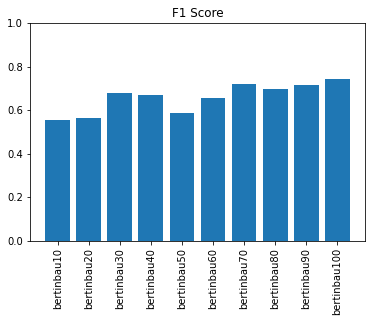

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['bertinbau10', 'bertinbau20', 'bertinbau30', 'bertinbau40', 'bertinbau50', 'bertinbau60', 'bertinbau70', 'bertinbau80', 'bertinbau90', 'bertinbau100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.43584567070435165, 0.45110732538330495, 0.5831759084342705, 0.5749945259470112, 0.4778173774118225, 0.5518816619534479, 0.6309696092619391, 0.6202947725585833, 0.6311845730027549, 0.6704972375690608]


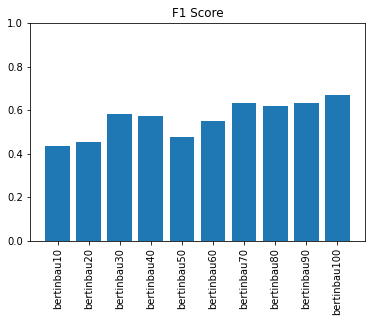

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['strict']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['bertinbau10', 'bertinbau20', 'bertinbau30', 'bertinbau40', 'bertinbau50', 'bertinbau60', 'bertinbau70', 'bertinbau80', 'bertinbau90', 'bertinbau100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.6200089726334679, 0.6505394662123795, 0.7578619846649627, 0.7365885701773593, 0.6651099913973209, 0.7309114639982598, 0.7914950461983749, 0.7555932562824728, 0.7792837465564739, 0.8072928176795581]


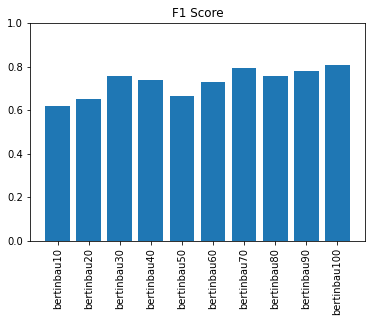

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['ent_type']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['bertinbau10', 'bertinbau20', 'bertinbau30', 'bertinbau40', 'bertinbau50', 'bertinbau60', 'bertinbau70', 'bertinbau80', 'bertinbau90', 'bertinbau100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.4537909376401974, 0.4572402044293015, 0.5869541060117791, 0.5826582001313773, 0.4876490106919012, 0.5616706547748532, 0.6345318935767561, 0.6232637048033082, 0.634931129476584, 0.6727071823204419]


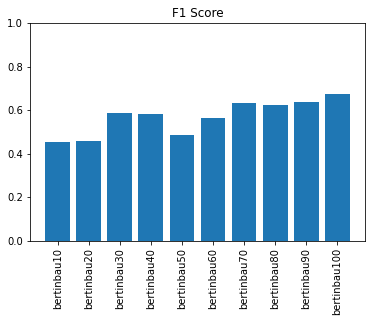

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['exact']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

### test 2


['bertinbau10', 'bertinbau20', 'bertinbau30', 'bertinbau40', 'bertinbau50', 'bertinbau60', 'bertinbau70', 'bertinbau80', 'bertinbau90', 'bertinbau100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
[0.4433734939759036, 0.4615881213686249, 0.7626774847870182, 0.767741935483871, 0.9068150208623088, 0.3227684346701164, 0.9439890710382514, 0.722662440570523, 0.5185185185185185, 0.6903914590747332, 0.22596548890714874, 0.430622009569378, 0.4427020506634499, 0.7406639004149378, 0.7981072555205048, 0.9015256588072121, 0.3724035608308605, 0.7126436781609196, 0.7471999999999999, 0.6382113821138211, 0.832000

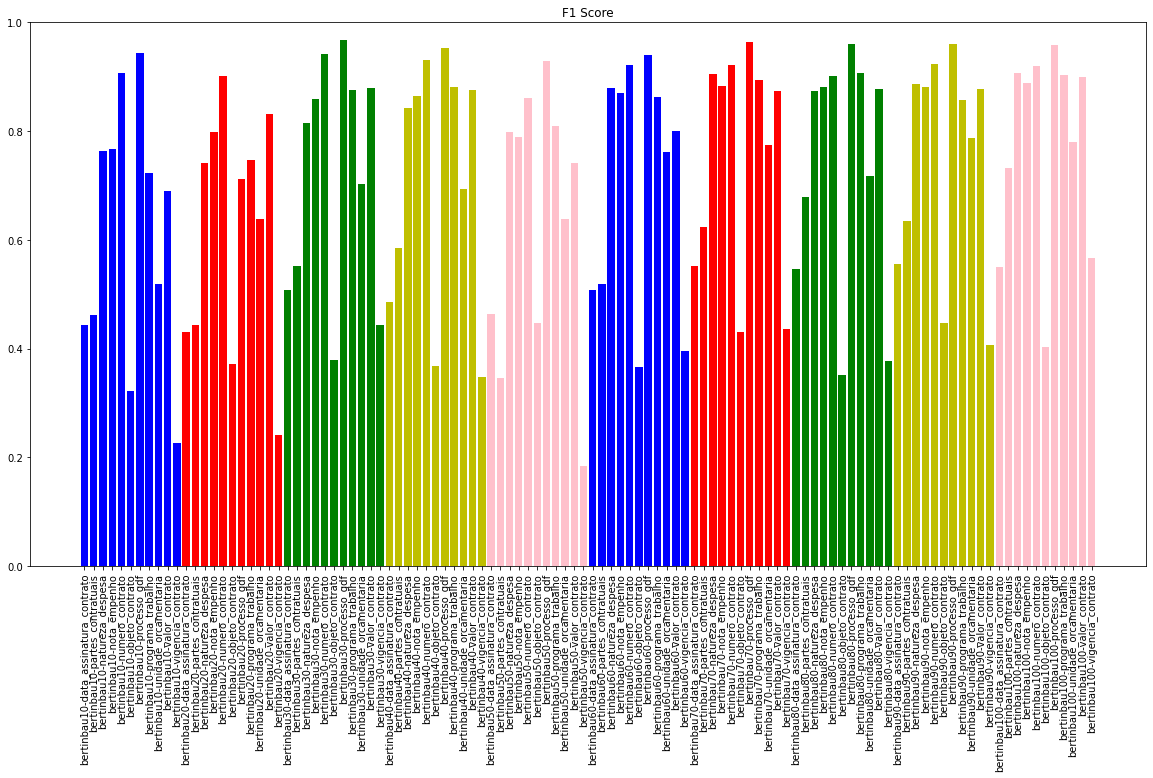

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*11 +['r']*11 +['g']*11 +['y']*11 + ['pink']*11 + ['b']*11 +['r']*11 +['g']*11 +['y']*11 + ['pink']*11

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")

plt.show()

['bertinbau10', 'bertinbau20', 'bertinbau30', 'bertinbau40', 'bertinbau50', 'bertinbau60', 'bertinbau70', 'bertinbau80', 'bertinbau90', 'bertinbau100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
[0.4433734939759036, 0.4615881213686249, 0.7626774847870182, 0.767741935483871, 0.9068150208623088, 0.3227684346701164, 0.9439890710382514, 0.722662440570523, 0.5185185185185185, 0.6903914590747332, 0.22596548890714874, 0.430622009569378, 0.4427020506634499, 0.7406639004149378, 0.7981072555205048, 0.9015256588072121, 0.3724035608308605, 0.7126436781609196, 0.7471999999999999, 0.6382113821138211, 0.832000

Text(0.5, 1.0, 'F1 Score')

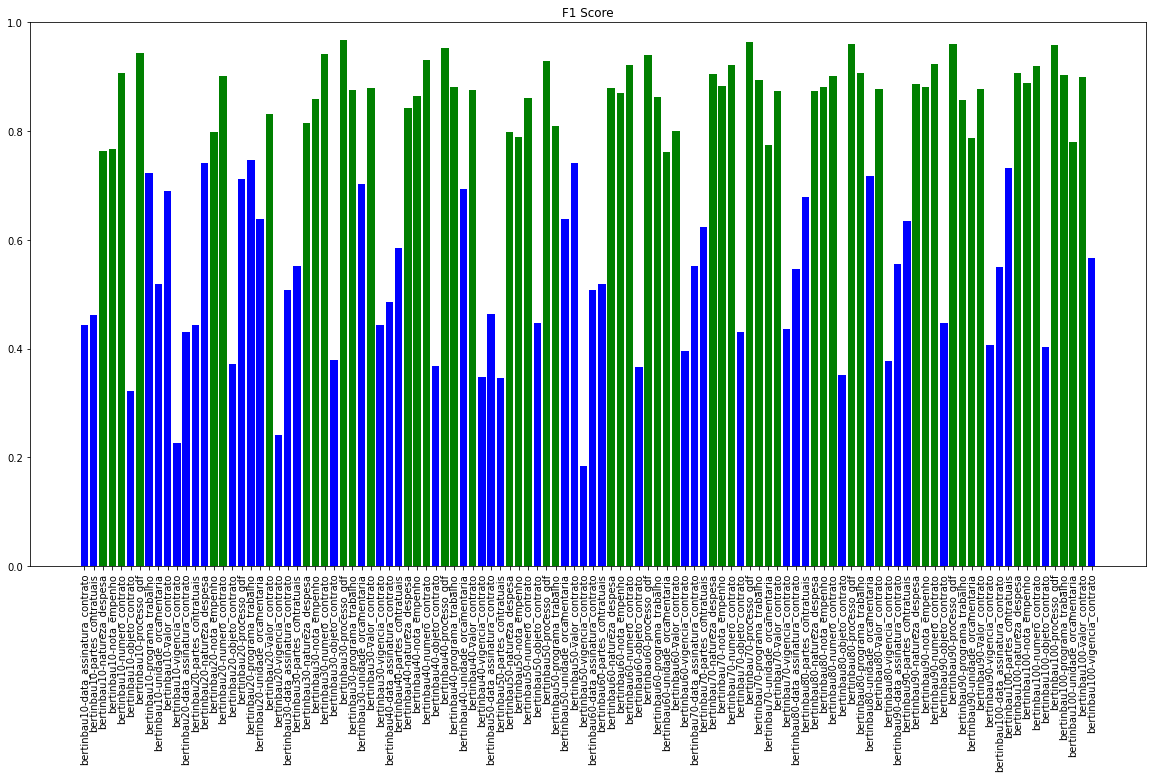

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*110

l_best = []
for i in range(len(y)):
  if y[i]>0.75:
    colors[i]='g'
    l_best.append(labels[i])
print(l_best)

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")


['bertinbau10', 'bertinbau20', 'bertinbau30', 'bertinbau40', 'bertinbau50', 'bertinbau60', 'bertinbau70', 'bertinbau80', 'bertinbau90', 'bertinbau100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.5536114849708389, 0.5624077228847245, 0.6776308478719858, 0.6699146047733743, 0.5884232518127074, 0.6560800522079617, 0.718913503283981, 0.6956844449157036, 0.7132782369146006, 0.7451933701657458]


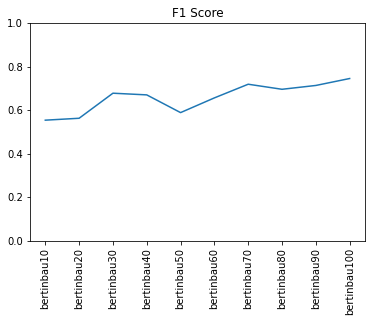

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)


fig, ax = plt.subplots(1, 1)
ax.plot(y) # adincionar linha
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['strict']['f1'] for x in xticks]
print(y)


fig, ax = plt.subplots(1, 1)
ax.plot(y) # adincionar linha
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()